In [121]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

import warnings
warnings.filterwarnings('ignore')

In [122]:
df = pd.read_csv("/Users/abbasmzehamadi/Downloads/ab_data.csv")
df.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


## Analyse exploratoire des données

In [123]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [124]:
# on regarde si on a des doublons
df.duplicated(subset ='user_id').sum()

3894

In [125]:
# on regarde les doublons pour la variable user_id
df[df["user_id"].duplicated()]

,user_id,timestamp,group,landing_page,converted
2656,698120,2017-01-15 17:13:42.602796,control,old_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0
7500,899953,2017-01-07 03:06:54.068237,control,new_page,0
8036,790934,2017-01-19 08:32:20.329057,treatment,new_page,0
10218,633793,2017-01-17 00:16:00.746561,treatment,old_page,0
...,...,...,...,...,...
294308,905197,2017-01-03 06:56:47.488231,treatment,new_page,0
294309,787083,2017-01-17 00:15:20.950723,control,old_page,0
294328,641570,2017-01-09 21:59:27.695711,control,old_page,0
294331,689637,2017-01-13 11:34:28.339532,control,new_page,0


In [126]:
df[df["user_id"]==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [127]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [129]:
df.columns.tolist()

['user_id', 'timestamp', 'group', 'landing_page', 'converted']



**user_id** : L'identifiant de l'utilisateur pour chaque session.

**timestamp** : L'horodatage de la session.

**group** : Définit si l'utilisateur est assigné au groupe Contrôle ou Traitement.

**landing_page** : Définit si l'utilisateur voit la page actuelle (old_page) ou la page à tester (new_page).

**converted** : Indique si la session s'est terminée par une conversion (binaire, 0 = non converti, 1 = converti).

In [130]:
pd.crosstab(df['group'], df['landing_page'])


landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


## Puissance statistique du modèle 

calcul du taux de conversion

Pour réaliser une analyse d’un test A/B, on suppose que le taux de conversion (nombre d’achats / nombre de visites) dans notre entreprise est de 12 %.
Nous aimerions augmenter ce taux à 14 %.
Par conséquent, nous avons mis en place un test A/B pour vérifier que la nouvelle version du site augmentera réellement le taux de conversion.

Pour décider du nombre de personnes nécessaires afin de valider ou rejeter l’hypothèse, nous devons réaliser une analyse de puissance statistique (power analysis).



In [132]:
effect_size = sms.proportion_effectsize(0.12, 0.14)    # Calcul de la taille de l’effet en fonction de nos taux attendus.

required_a = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8,  #power of a test (defualt is 0.8)
    alpha=0.05, #p-value
    ratio=1
    )                                                  # Calculating sample size needed

required_a = ceil(required_a)                          # Rounding up to next whole number                          

print(required_a)


4433


on a besoin au minimum de 5934 dans le groupe de contrôle et 5934 dans le groupe de traitement

## Echantillonnage

Nous avons vu au préalable qu'il y a des doublons qu'il faut traiter

In [133]:
df.user_id.value_counts()

user_id
805339    2
754884    2
722274    2
783176    2
898232    2
         ..
642985    1
771499    1
923606    1
712675    1
715931    1
Name: count, Length: 290584, dtype: int64

Certains utilisateurs apparaissent plusieurs fois dans le jeu de données.
Supprimons simplement les doublons.

In [134]:
session_counts = df.user_id.value_counts()
double_users = session_counts[session_counts>1].index

double_users

Index([805339, 754884, 722274, 783176, 898232, 899018, 904570, 842042, 881123,
       858720,
       ...
       721188, 902463, 713355, 827417, 655283, 847058, 889392, 664150, 835401,
       736955],
      dtype='int64', name='user_id', length=3894)

In [135]:
df['user_id'].isin(double_users).value_counts()

user_id
False    286690
True       7788
Name: count, dtype: int64

In [136]:
df = df[~df['user_id'].isin(double_users)]
df.shape

(286690, 5)

On prend 5934 utilisateurs au hasard du groupe contrôle, et 5000 du groupe traitement, pour comparer les taux de conversion.

In [137]:
control_group = df.query('group == "control"').sample(required_a)
treatment_group = df.query('group == "treatment"').sample(required_a)


In [138]:
treatment_group.head()

,user_id,timestamp,group,landing_page,converted
65286,738265,2017-01-21 20:36:09.530397,treatment,new_page,0
200538,781915,2017-01-20 13:55:50.975976,treatment,new_page,0
269421,870135,2017-01-23 06:16:47.677151,treatment,new_page,1
69050,772617,2017-01-18 18:18:33.555251,treatment,new_page,0
224279,839088,2017-01-23 07:07:31.755113,treatment,new_page,0


In [139]:
control_group.head()


,user_id,timestamp,group,landing_page,converted
165858,787860,2017-01-03 03:16:14.733713,control,old_page,0
80999,686950,2017-01-19 02:51:48.084714,control,old_page,0
28035,915677,2017-01-21 03:35:11.209814,control,old_page,0
114698,870483,2017-01-16 09:38:21.961180,control,old_page,0
142779,824166,2017-01-24 09:42:36.372887,control,old_page,1


In [140]:
#concaténation des deux data frame
ab_test = pd.concat([control_group, treatment_group], axis=0)

#Les indices sont réinitialisés 
ab_test.reset_index(inplace=True, drop=True)

In [141]:
ab_test.head()

,user_id,timestamp,group,landing_page,converted
0,787860,2017-01-03 03:16:14.733713,control,old_page,0
1,686950,2017-01-19 02:51:48.084714,control,old_page,0
2,915677,2017-01-21 03:35:11.209814,control,old_page,0
3,870483,2017-01-16 09:38:21.961180,control,old_page,0
4,824166,2017-01-24 09:42:36.372887,control,old_page,1


In [142]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8866 entries, 0 to 8865
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       8866 non-null   int64 
 1   timestamp     8866 non-null   object
 2   group         8866 non-null   object
 3   landing_page  8866 non-null   object
 4   converted     8866 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 346.5+ KB


In [143]:
ab_test.group.value_counts()

group
control      4433
treatment    4433
Name: count, dtype: int64

In [144]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=1)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=1)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.120,0.325,0.005
treatment,0.122,0.328,0.005


le groupe de controle montre un taux de conversion de 12% tandis que le groupe de traitement montre un taux de conversion de 12.2%

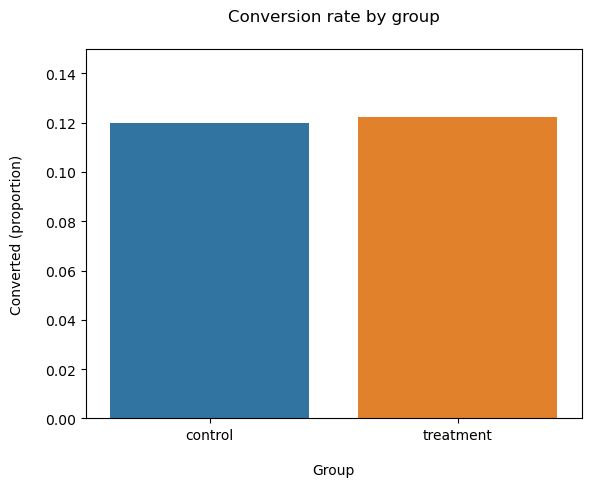

In [145]:
sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.15)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

on voit une legère augmentation, maintenant on va voir si cette diffèrence est signficiative

## Test d'hypothèse

On ne fait pas de test de normalité ici car, étant donné la grande taille de l'échantillon, le Théorème Central Limite garantit que la distribution de la proportion suit une distribution approximativement normale, ce qui permet d'appliquer directement le Z-test de proportion.

In [146]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [147]:
control_conversion = ab_test.query('group == "control"')['converted']
treatment_conversion = ab_test.query('group == "treatment"')['converted']

In [148]:
nobs = [control_conversion.count(), treatment_conversion.count()]
successes = [control_conversion.sum(), treatment_conversion.sum()]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'95% Confidence interval for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'95% Confidence interval for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.36
p-value: 0.720
95% Confidence interval for control group: [0.110, 0.130]
95% Confidence interval for treatment group: [0.113, 0.132]


La p-value calculée à partir du test d'hypothèse est de **0.720**, ce qui dépasse le niveau de signification (0.05). En conséquence, **nous ne pouvons pas rejeter l'hypothèse nulle**. Le test statistique n'a pas trouvé de preuve significative pour conclure qu'il existe une **différence significative** dans les taux de conversion entre les deux conceptions de pages d'atterrissage. En d'autres termes, la différence observée dans les taux de conversion peut être attribuée à une **variation aléatoire** plutôt qu'à un véritable effet du changement de conception.

Bien que les résultats du test A/B n'indiquent pas de différence statistiquement significative dans les taux de conversion, la petite différence observée suggère que les deux conceptions de pages d'atterrissage fonctionnent de manière similaire en termes de conversion des utilisateurs. Pour optimiser davantage les pages d'atterrissage et augmenter les taux de conversion, des analyses et considérations supplémentaires peuvent être nécessaires.